#\ - comments that should be delected at some point and should be looked into if they still remain in the code, possible represent future endeavors
#comment - former or temp lines of code that are currently commented, either need to be deleted or uncommented to be used again at some point
- #_comment - # comment - represents an actual comment that should stay in the code after finished, describes the code in some way or provides clarity


In [758]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from matplotlib.markers import MarkerStyle
import networkx as nx

# Graph function

In [759]:
# This class controls all the information for how to set up and display the graph, 
#   so it displays the graph information and the pymoo optimizations
class Graph: 
    # Code for showing the initial graph
    # numN = number of nodes
    # uppB = upperbounds of x
    # lowB = lowerbounds of x
    # precision = the decimal place the numbers will be to (ex: precision = 1 means that it will be to the tenths or .1 precision)
    # seed = the random seed to ensure the results are repeatable
    # costA = array of all the nodes cost (distance) to one another
    # xc = x coordinates of locations
    # yc = y coordinate of locations
    # connectivityMatrix = shows connections of the 
    def __init__(self, numN, uppB, lowB, precision, seedNum):
        self.numN = numN
        self.uppB = uppB
        self.lowB = lowB
        self.precision = precision
        self.seedNum = seedNum
        self.nodes = None
        self.costA = None
        self.xc = None
        self.yc = None
        self.connectivityMatrix= None
        self.score = None
        self.correctScore= None
        self.genNodes()
        
    
    # displays the graph with the supplied informaion
    # showEdges - boolean value used to determine if the graph with show connections or not
    def showGraph(self, showEdges, showCost, showConnectivityMatrix):

        rnd = np.random
        rnd.seed(self.seedNum)
        # prints the original graph and the backgrounds for the ids of the nodes
        plt.scatter(self.xc,
                    self.yc, 
                    s = 150,
                    marker = MarkerStyle("o"), 
                    facecolors='white', 
                    edgecolors='blue',
                    zorder = 3)
        
        # Displays the ids of each node
        for i in range (0, self.numN):
               plt.text(self.xc[i], self.yc[i], i+1, horizontalalignment='center', verticalalignment='center')
        
        # prints out the connections between nodes and the costs
        if showConnectivityMatrix == False:
            for i in range(0, self.numN-1):
                for j in range (0, self.numN):
                    if (i != j):
                        if (showEdges == True):
                            # if showEdges is true, prints out the connections between all the nodes
                            plt.plot([self.xc[i], self.xc[j]], [self.yc[i], self.yc[j]], color = 'black', zorder = 0)
                        # Shows the cost of each connection
                        if (showCost == True):
                            # if showCost is true, shows the cost of each connection
                            plt.text((self.xc[i]+self.xc[j])/2,(self.yc[i]+self.yc[j])/2, s=self.costA[i][j], horizontalalignment='center', verticalalignment='center', zorder = 2, color = 'green', bbox=dict(boxstyle='square', facecolor = 'white', edgecolor='black', zorder=1))
        # prints out the graph of the connectivity matrix (which will be the solution pymoo has found)
        else:
            for i in range (0, self.numN):
                for j in range (0, self.numN):
                    if (self.connectivityMatrix[i][j]!=0):
                        if (showEdges == True):
                            plt.plot([self.xc[i], self.xc[j]], [self.yc[i], self.yc[j]], color = 'black', zorder = 0)
                        if (showCost == True):
                            plt.text((self.xc[i]+self.xc[j])/2,(self.yc[i]+self.yc[j])/2, s=self.costA[i][j], horizontalalignment='center', verticalalignment='center', zorder = 2, color = 'green', bbox=dict(boxstyle='square', facecolor = 'white', edgecolor='black', zorder=1))
        # displays the score
        #self.score = 25
        #self.correctScore = 35
        #if self.score is not None:
                #plt.title( Label = ("Score" + self.score + "   Correct score" + self.correctScore))

    # displays the 2d arrays howing the costs between all the nodes
    def showCost(self):
        print(self.costA)
        
    # generates the random nodes, and calculates the cost (distance) 
    #   between every node in the graph and stores it in a 2D array
    #   and then stores this information in nodes and costA respectively
    # returns a np.array of the costs to each node
    def genNodes(self):
        
        rnd = np.random
        rnd.seed(self.seedNum)
        xc = rnd.rand(self.numN)*200
        yc = rnd.rand(self.numN)*100
        self.xc = xc
        self.yc = yc

        # set of clients
        N = [i for i in range(1,self.numN)]
        V = [0] + N
        self.nodes = np.array(V)
        
        # connecting every point to every point
        A = [(i,j) for i in V for j in V if i!=j]
        costArr = np.zeros((self.numN,self.numN))
        # Generates cost between vertices
        for i,j in A :
            costArr[i][j] = np.hypot(xc[i]-xc[j],yc[i]-yc[j])
            if (i==j):
                costArr[i][j] = 0
            costArr[i][j] = costArr[i][j].round(self.precision)

        self.costA = costArr
   
    # sets the connectivity matrix equal to the solution found by pymoo
    def set_connectivity(self, connection_order):

        connectivityMatrix = np.full( ( self.numN, self.numN), 0)

        previous = None
        for i, connection in enumerate(connection_order):
            if i == 0:
                previous = connection
            else:
                connectivityMatrix[previous][connection] = i+1
                previous = connection
        self.connectivityMatrix = connectivityMatrix

    # Determines the longest path of the graph
    def setScore(self, score):
        self.score = score

        G = nx.from_numpy_array(self.costA)
        #for row in self.costA:
            #for index in self.costA:
                #print (list(nx.all_simple_paths(G, index, row)))
                #print("G.nodes: ") 
                #print(G.nodes)
                #print("G.edges: ")
                #print(G.edges)
                #print("row: ")
                #print(row)
                #print("index: ")
                #print(index)
                #print("test")


## This Block is to test the graph function without any pymoo input

[[  0.  112.7  24.1 170.5 157.3  63. ]
 [112.7   0.   98.2  61.5  44.9  61.4]
 [ 24.1  98.2   0.  158.5 143.1  60.4]
 [170.5  61.5 158.5   0.   22.7 111.3]
 [157.3  44.9 143.1  22.7   0.  101.9]
 [ 63.   61.4  60.4 111.3 101.9   0. ]]


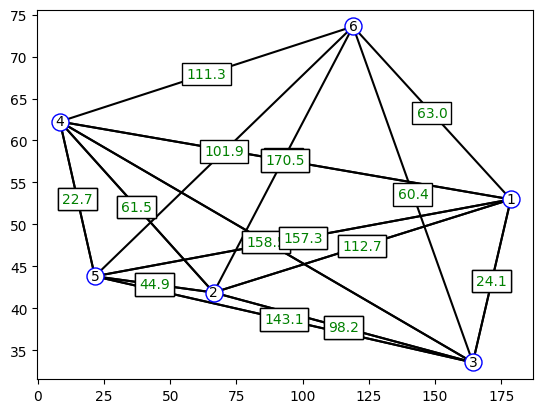

In [760]:
numN = 6
uppB = 1
lowB = 0
precision = 1
seedNum = 6
gTest = Graph(numN, uppB, lowB, precision, seedNum)
gTest.showGraph(showEdges=True, showCost=True, showConnectivityMatrix=False)
gTest.showCost()

In [761]:
#element wise problem looks at one solution at a time, normal problem would look at all problems at once
class longestPath(ElementwiseProblem):
    def __init__(self, graph): # initilization/constructor function

        self.graph = graph
        # n_var = number of connections, n_obj=?, n_ieq_constr=?, x1 = 1 (lowest node besides 0 as 0 can't conenct to itself), xu = number of nodes minus 1 (because ids start at 0)
        super().__init__(n_var=graph.numN, n_obj=1, n_ieq_constr=0, xl=0, xu=graph.numN-1)
        

    #x is a random solution or population to the problem, that is automatically created
    def _evaluate(self, x, out, *args, **kwargs): 
        
        self.graph.set_connectivity( x )
        
        # fills in the array with all the connection distances (when there is a connection (c=1), assign the length to the dist_matrix, otherwise mark the distance as 0 to show theres no connection)
        dist_mask = np.array(np.where(self.graph.connectivityMatrix != 0, self.graph.costA, 0))
        #set the score
        gTest.setScore(score=np.sum(dist_mask))
        # determines if the solution only contains each value once, if it doesn't, then its penalized
        uniqueList = np.unique(x)
        num_unique = uniqueList.size
        # the lower the number below is, the more it will like the result
        out["F"] = -np.sum(dist_mask) + ((self.graph.numN - num_unique)*1000)


In [762]:
problem = longestPath(gTest)

# take the best 1 out of the 2 generated solutions (pop_size) and use them to breed the next generation, this will happen for 10 (n_gen) generations
algorithm = GA(
    pop_size=10,
    sampling=IntegerRandomSampling(),
    # how the solutions are passed onto each generations
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=False)

res = minimize(problem,
            algorithm,
            termination=('n_gen', 100),
            seed=1,
            save_history=False)

[1 5 4 0 3 2]


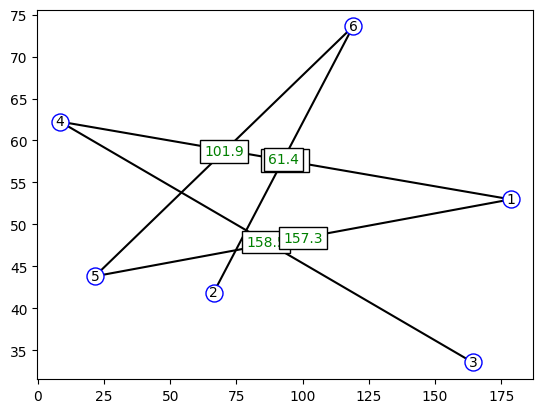

In [763]:
gTest.set_connectivity(res.X)
print(res.X)
gTest.showGraph(showEdges=True, showCost=True, showConnectivityMatrix=True)